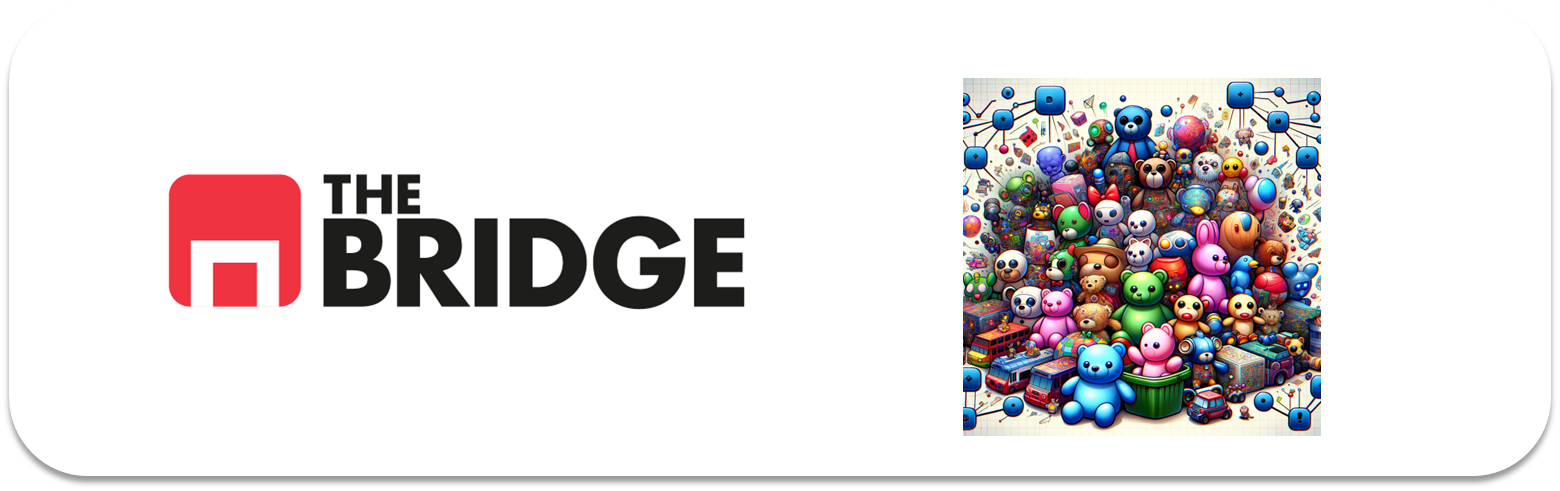

## PRACTICA OBLIGATORIA: **DBSCAN y Clustering Jerárquico**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

import bootcampviztools as bvt

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


Shape: (153, 5)
                       count      mean       std       min       25%  \
Azúcares               153.0  0.019231  1.026182 -2.434235 -0.816038   
Vitamínas del grupo B  153.0  0.037273  0.995984 -3.679162 -0.499016   
Cafeína                153.0  0.041057  1.040928 -1.695971 -1.043392   
Ácido Cítrico          153.0  0.080022  1.009450 -1.493188 -0.738463   
Taurina                153.0 -0.044088  0.934399 -1.634288 -0.799428   

                            50%       75%       max  
Azúcares               0.061000  0.876275  2.259772  
Vitamínas del grupo B -0.023821  0.707247  3.156325  
Cafeína                0.211566  0.894264  3.062832  
Ácido Cítrico         -0.165254  0.917474  2.971473  
Taurina               -0.154899  0.493956  2.431870  


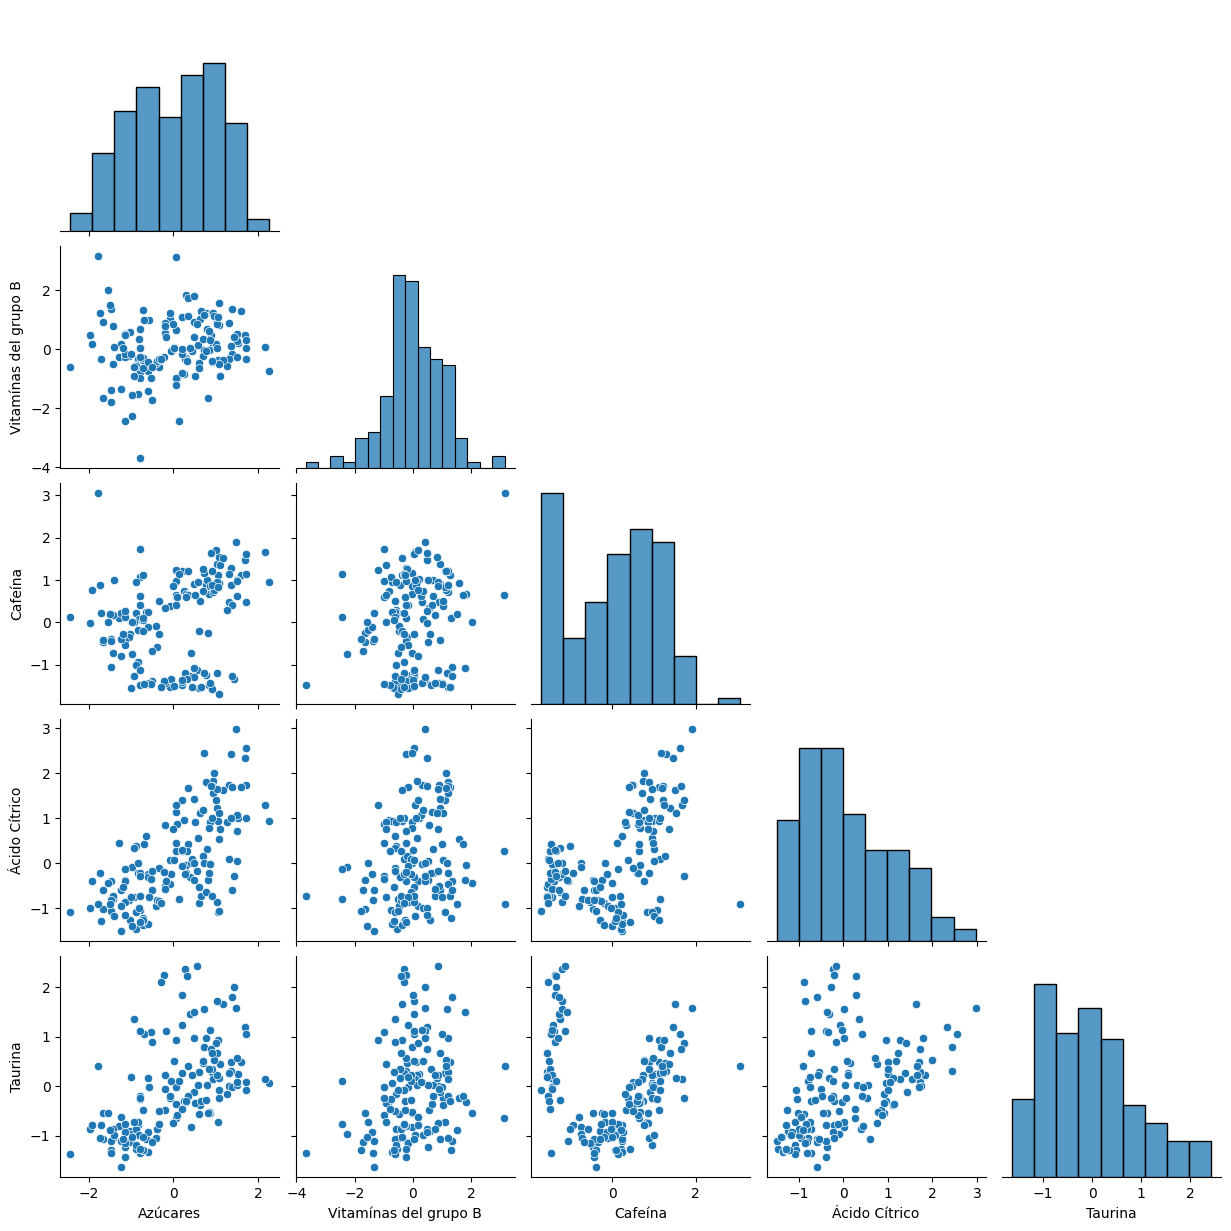

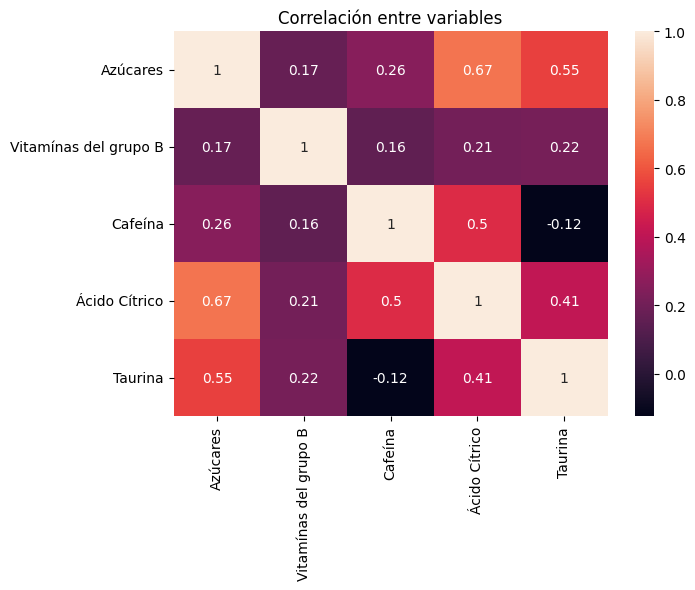

,k,silhouette
0,3,0.376469
1,4,0.328786
2,5,0.293075


Mejor k por silueta: 3 (sil=0.3765)


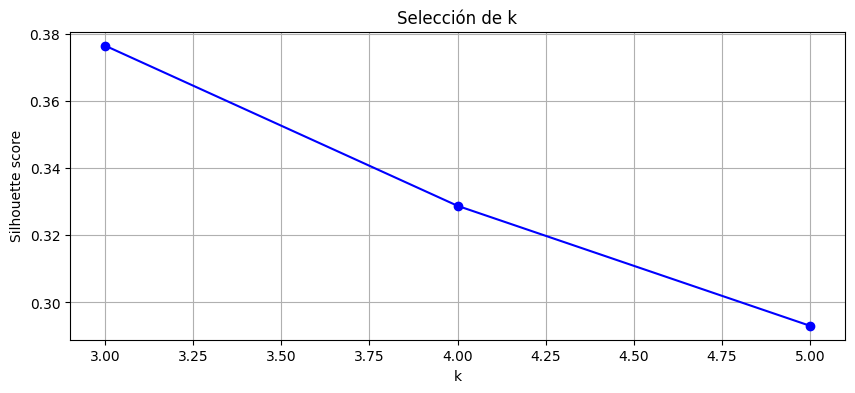

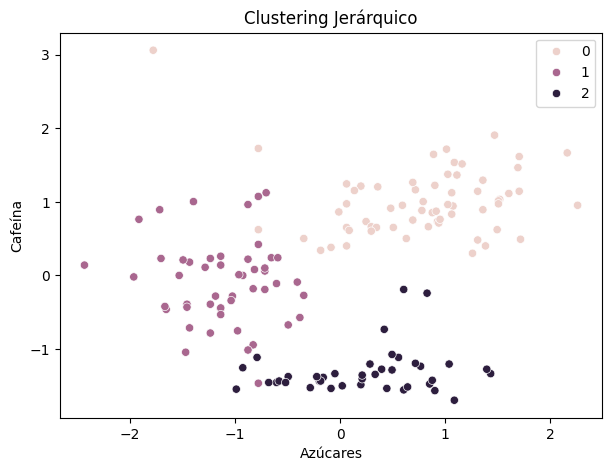

,eps,min_samples,n_clusters,frac_noise,silhouette
5,1.1,8,3,0.202614,0.457382
2,1.0,5,3,0.215686,0.456290
4,1.1,7,3,0.176471,0.447999
7,1.2,10,3,0.130719,0.439473
6,1.2,9,3,0.091503,0.428629
3,1.1,6,3,0.098039,0.424099
0,1.0,3,4,0.124183,0.383918
1,1.0,4,4,0.150327,0.356366


Mejor DBSCAN: eps=1.1, min_samples=8


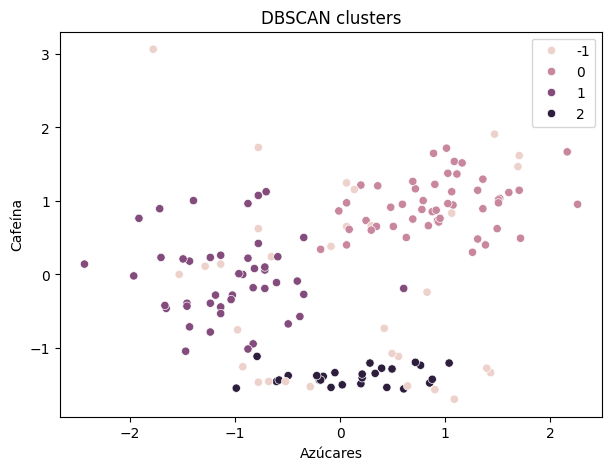


--- Comparación rápida ---
Jerárquico (k=3) silhouette: 0.37646936486414423
DBSCAN (eps=1.1, ms=8) silhouette: 0.4573819324862657


In [ ]:
# ------------------------------------------------------------
# Modelado
# ------------------------------------------------------------
df = pd.read_csv("data/empowering_drinks.csv", sep="|")
display(df.head())
print("Shape:", df.shape)
print(df.describe().T)

# Mini-EDA: relaciones dos a dos
sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(df.corr(), annot=True)
plt.title("Correlación entre variables")
plt.show()

# Tratamiento de features: escalado (importante para DBSCAN y distancias en general)
scaler = StandardScaler()
X = df.values
X_s = scaler.fit_transform(X)

# ------------------------------------------------------------
# Modelo 1: Clustering Jerárquico
# ------------------------------------------------------------

k_candidates = [3, 4, 5]  # según nota orientativa
agg_results = []
for k in k_candidates:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_s)
    score = silhouette_score(X_s, labels)
    agg_results.append((k, score))

agg_results_df = pd.DataFrame(agg_results, columns=["k", "silhouette"])
display(agg_results_df.sort_values("silhouette", ascending=False))

best_k_agg = int(agg_results_df.loc[agg_results_df["silhouette"].idxmax(), "k"])
best_sil_agg = float(agg_results_df["silhouette"].max())
print(f"Mejor k por silueta: {best_k_agg} (sil={best_sil_agg:.4f})")

best_agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward")
labels_agg = best_agg.fit_predict(X_s)

plt.figure(figsize=(10,4))
plt.plot(agg_results_df["k"], agg_results_df["silhouette"], "bo-")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Selección de k")
plt.grid(True)
plt.show()

# Visualización de 2 features
plt.figure(figsize=(7,5))
sns.scatterplot(x=df.columns[0], y=df.columns[2], hue=labels_agg, data=df)
plt.title("Clustering Jerárquico")
plt.show()

# ------------------------------------------------------------
# Modelo 2: DBSCAN
# ------------------------------------------------------------


eps_grid = np.linspace(0.3, 2.5, 23)
min_samples_grid = range(3, 11)

dbscan_candidates = []
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=float(eps), min_samples=int(ms))
        labels = db.fit_predict(X_s)
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        # buscamos entre 3-5 cluster
        if 3 <= n_clusters <= 5:
            frac_noise = 1 - mask.mean()
            # nos quitamos ruido
            if frac_noise > 0.25:
                continue
            sil = silhouette_score(X_s[mask], labels[mask])
            dbscan_candidates.append((eps, ms, n_clusters, frac_noise, sil))

dbscan_df = pd.DataFrame(
    dbscan_candidates,
    columns=["eps", "min_samples", "n_clusters", "frac_noise", "silhouette"]
).sort_values(["silhouette", "frac_noise"], ascending=[False, True])

display(dbscan_df.head(10))

best_eps = float(dbscan_df.iloc[0]["eps"])
best_ms  = int(dbscan_df.iloc[0]["min_samples"])
print(f"Mejor DBSCAN: eps={best_eps}, min_samples={best_ms}")

best_db = DBSCAN(eps=best_eps, min_samples=best_ms)
labels_db = best_db.fit_predict(X_s)

mask = labels_db != -1

plt.figure(figsize=(7,5))
sns.scatterplot(x=df.columns[0], y=df.columns[2], hue=labels_db, data=df)
plt.title("DBSCAN clusters")
plt.show()

# ------------------------------------------------------------
# Comparación
# ------------------------------------------------------------

print("\n--- Comparación rápida ---")
print(f"Jerárquico (k={best_k_agg}) silhouette: {best_sil_agg}")
# silhouette DBSCAN solo en no-ruido
sil_db = silhouette_score(X_s[mask], labels_db[mask])
print(f"DBSCAN (eps={best_eps}, ms={best_ms}) silhouette: {sil_db}")

# ------------------------------------------------------------


### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [ ]:
new_df = pd.read_csv("data/new_experiments.csv", sep="|")
display(new_df)

X_new_s = scaler.transform(new_df.values)

# segmentar nuevos puntos con DBSCAN
X_all_s = np.vstack([X_s, X_new_s])
db_all = DBSCAN(eps=best_eps, min_samples=best_ms).fit(X_all_s)
labels_all_db = db_all.labels_

labels_new_db = labels_all_db[-len(new_df):]
new_df_seg = new_df.copy()
new_df_seg["cluster_dbscan"] = labels_new_db

# Con jerárquico
agg_all = AgglomerativeClustering(n_clusters=best_k_agg, linkage="ward").fit(X_all_s)
labels_all_agg = agg_all.labels_
labels_new_agg = labels_all_agg[-len(new_df):]

new_df_seg["cluster_agg"] = labels_new_agg
print("\nNuevos experimentos segmentados (DBSCAN y Jerarquicos):")
display(new_df_seg)

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043



Nuevos experimentos segmentados (DBSCAN y Jerarquicos):


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,cluster_dbscan,cluster_agg
0,1.481555,0.305159,1.366128,2.239039,0.731870,0,1
1,0.616869,0.890014,0.583034,0.312420,-0.665332,0,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,1,0
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,1,0
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,-1,2
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,2,2


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [ ]:
# Parte III. EXTRA: Evaluación con resultados
# buscado en foro de internet las funciones:
# - adjusted_rand_score para saber cuanto se parecen las particiones ARI: Adjusted Rand Index
# - normalized_mutual_info_score para saber cuánta información comparten ambas asignaciones de etiquetas NMI: Normalized Mutual Information
# ------------------------------------------------------------
power = pd.read_csv("data/power_results.csv", sep="|")
y_true = power.iloc[:, 0].values
print("y_true shape:", power.shape)

ari_db  = adjusted_rand_score(y_true, labels_all_db)
nmi_db  = normalized_mutual_info_score(y_true, labels_all_db)

ari_agg = adjusted_rand_score(y_true, labels_all_agg)
nmi_agg = normalized_mutual_info_score(y_true, labels_all_agg)

print("\n--- Evaluación (EXTRA) ---")
print(f"DBSCAN  -> ARI: {ari_db:.4f} | NMI: {nmi_db:.4f}")
print(f"JERARQUICO     -> ARI: {ari_agg:.4f} | NMI: {nmi_agg:.4f}")

y_true shape: (159, 1)

--- Evaluación (EXTRA) ---
DBSCAN  -> ARI: 0.7234 | NMI: 0.7213
JERARQUICO     -> ARI: 0.8458 | NMI: 0.8364
